<a href="https://colab.research.google.com/github/santoshkumarbvp/NIFTY50-Web-Application/blob/main/NIFTY50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
import ast
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense,  \
                         BatchNormalization, Flatten, Reshape, Concatenate, add
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

from tensorflow.keras.layers import concatenate, add

from tensorflow.keras.utils import plot_model

In [28]:
!nvidia-smi

Sat Feb 13 15:43:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
tf.__version__

'2.4.1'

In [30]:
t1 = time.time()

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Data/processed_data.csv')

In [32]:
df.head()

,Unnamed: 0,Date,Open,Year,Month,Day,Headlines,Stock_var
0,1,2014-01-02,6301.250000,2014,January,2,"['Stricter energy norms to push up AC, fridge ...",NaN
1,2,2014-01-03,6194.549805,2014,January,3,"['NEERI team to study mining impact', 'Jobs & ...",-106.700195
2,3,2014-01-06,6220.850098,2014,January,6,"['Teesta Setalvad, husband booked for usurping...",26.300293
3,4,2014-01-07,6203.899902,2014,January,7,['AAP government suspends 3 Delhi Jal Board of...,-16.950196
4,5,2014-01-08,6178.049805,2014,January,8,['Lok Sabha elections: No decision yet on quan...,-25.850097


In [33]:
df.dropna(inplace=True) # removing null rows

In [34]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [35]:
df.head()

,Date,Open,Year,Month,Day,Headlines,Stock_var
1,2014-01-03,6194.549805,2014,January,3,"['NEERI team to study mining impact', 'Jobs & ...",-106.700195
2,2014-01-06,6220.850098,2014,January,6,"['Teesta Setalvad, husband booked for usurping...",26.300293
3,2014-01-07,6203.899902,2014,January,7,['AAP government suspends 3 Delhi Jal Board of...,-16.950196
4,2014-01-08,6178.049805,2014,January,8,['Lok Sabha elections: No decision yet on quan...,-25.850097
5,2014-01-09,6181.700195,2014,January,9,['AAP soon to clear its stand on national poli...,3.650390


In [36]:
df_news = df[['Date','Headlines']]

In [37]:
df_stock = df[['Date','Stock_var']]

In [38]:
df_news.shape, df_stock.shape

((1711, 2), (1711, 2))

In [39]:
df_stock.head()

,Date,Stock_var
1,2014-01-03,-106.700195
2,2014-01-06,26.300293
3,2014-01-07,-16.950196
4,2014-01-08,-25.850097
5,2014-01-09,3.650390


In [40]:
df_news.Headlines = df_news.Headlines.map(ast.literal_eval)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
df_news = df_news.explode('Headlines')

In [42]:
df_news.shape

(17015, 2)

In [43]:
df_news.head()

,Date,Headlines
1,2014-01-03,NEERI team to study mining impact
1,2014-01-03,Jobs & career: Companies give appraisals a mor...
1,2014-01-03,Coal India misses April-December output target...
1,2014-01-03,Private equity firms invest about Rs 940 crore...
1,2014-01-03,"IBM, ST Microelectronics only players keen on ..."


In [44]:
# removing special character '/'

In [45]:
# Transferring the data into list

price = []
headlines = []

for row in df_stock.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Stock_var'])
    for row_ in df_news[df_news.Date==date].iterrows():
        daily_headlines.append(row_[1]['Headlines'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500


In [46]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))

1711
1711


In [47]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
print(np.mean(list((len(i) for i in headlines))))

10
6
9.94447691408533


In [48]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [49]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [50]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [51]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [52]:
    
len(clean_headlines)

1711

In [53]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 19488


In [54]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/Data/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 400000


In [55]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 49
Percent of words that are missing from vocabulary: 0.25%


In [56]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 19488
Number of Words we will use: 16856
Percent of Words we will use: 86.49%


In [57]:
embedding_dim = 100

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

16856


In [58]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 143566
Total number of UNKs in headlines: 3829
Percent of words that are UNK: 2.67%


In [59]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [60]:
# Limit the length of a day's news to 100 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 100
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [61]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [62]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [63]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5654056599419871


In [64]:
len(pad_headlines), len(norm_price)

(1711, 1711)

In [65]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [66]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1454
257


In [67]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.0001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True


model1 = Sequential()
    
model1.add(Embedding(nb_words,
                     embedding_dim,
                     weights=[word_embedding_matrix], 
                     input_length=max_daily_length, name='Model1_embedding'))
model1.add(Dropout(dropout,name='Model1_dropout1'))
    
model1.add(Convolution1D(filters = nb_filter, 
                     kernel_size = filter_length1, 
                     padding = 'same',
                     activation = 'relu', name='Model1_conv1d'))
model1.add(Dropout(dropout,name='Model1_dropout2'))
    
if deeper == True:
  model1.add(Convolution1D(filters = nb_filter,
                      kernel_size = filter_length1, 
                      padding = 'same',
                      activation = 'relu'))
model1.add(Dropout(dropout,name='Model1_dropout3'))
    
model1.add(LSTM(rnn_output_size, 
                     activation=None,
                     kernel_initializer=weights,
                     dropout = dropout, name='Model1_LSTM'))
# model1.compile(loss='mean_squared_error',
#                   optimizer=Adam(lr=learning_rate,clipvalue=1.0) )

In [68]:
model2 = Sequential()
    
model2.add(Embedding(nb_words,
                     embedding_dim,
                     weights=[word_embedding_matrix], 
                     input_length=max_daily_length,name='Model2_embedding'))
model2.add(Dropout(dropout,name='Model2_dropout'))
    
model2.add(Convolution1D(filters = nb_filter, 
                     kernel_size = filter_length1, 
                     padding = 'same',
                     activation = 'relu', name='Model2_conv1d'))
model2.add(Dropout(dropout,name='Model2_dropout2'))

    
if deeper == True:
  model2.add(Convolution1D(filters = nb_filter,
                      kernel_size = filter_length1, 
                      padding = 'same',
                      activation = 'relu'))
model2.add(Dropout(dropout, name='Model2_dropout3'))
    
model2.add(LSTM(rnn_output_size, 
                     activation=None,
                     kernel_initializer=weights,
                     dropout = dropout, name='Model2_LSTM'))
# model2.compile(loss='mean_squared_error',
#                   optimizer=Adam(lr=learning_rate,clipvalue=1.0) )


In [69]:
concatenated = concatenate([model1.output, model2.output], axis=-1)
    
output = Dense(64, activation= 'relu',kernel_initializer=weights,name='model_dense0')(concatenated)
output = Dropout(0.4,name='model_dropout01')(output)
output = Dense(1, kernel_initializer=weights,name='model_dense1')(output)
# output = Dropout(0.4,name='model_dropout02')(output)
# output = Dense(1, kernel_initializer=weights,name='model_dense2')(output)
# output = Dropout(0.4,name='model_dropout03')(output)

model = Model(inputs=[model1.input, model2.input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Model1_embedding_input (InputLa [(None, 100)]        0                                            
__________________________________________________________________________________________________
Model2_embedding_input (InputLa [(None, 100)]        0                                            
__________________________________________________________________________________________________
Model1_embedding (Embedding)    (None, 100, 100)     1685600     Model1_embedding_input[0][0]     
__________________________________________________________________________________________________
Model2_embedding (Embedding)    (None, 100, 100)     1685600     Model2_embedding_input[0][0]     
______________________________________________________________________________________________

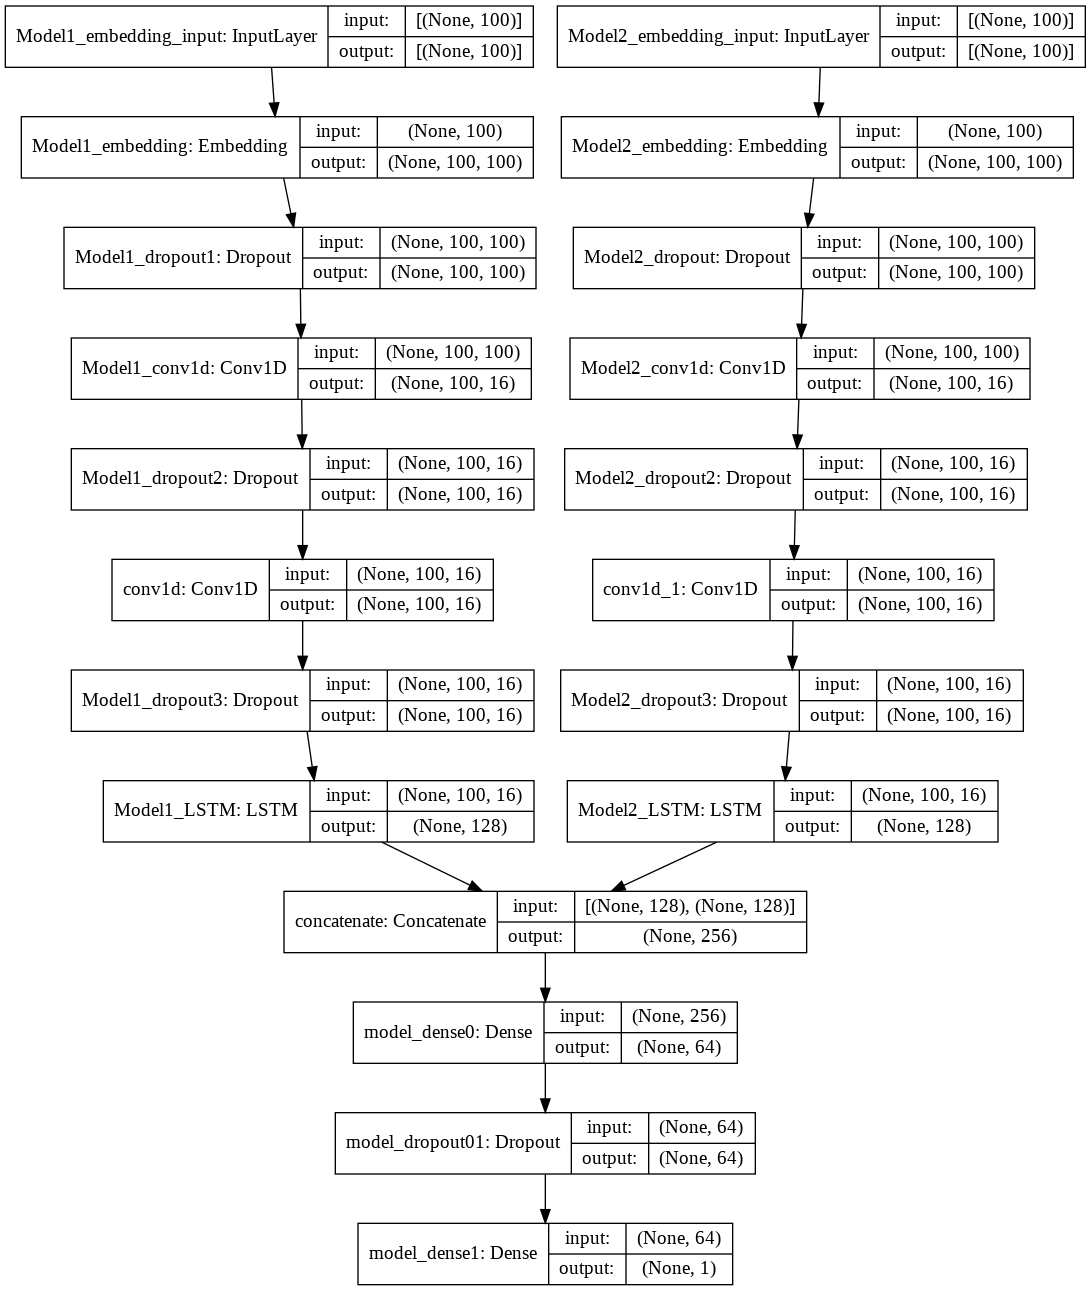

In [70]:
plot_model(model,show_shapes=True, expand_nested=True)


In [71]:

model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate))

In [78]:
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"

callbacks = [ModelCheckpoint(filepath=filepath,  monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=30)]


In [79]:
history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=32,
                                    epochs=1000,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)

Epoch 1/1000
39/39 [==============================] - 13s 328ms/step - loss: 0.0388 - val_loss: 0.1018
Epoch 2/1000
39/39 [==============================] - 13s 323ms/step - loss: 0.0414 - val_loss: 0.1018
Epoch 3/1000
39/39 [==============================] - 12s 311ms/step - loss: 0.0391 - val_loss: 0.1018
Epoch 4/1000
39/39 [==============================] - 13s 340ms/step - loss: 0.0365 - val_loss: 0.1018
Epoch 5/1000
39/39 [==============================] - 12s 319ms/step - loss: 0.0356 - val_loss: 0.1017
Epoch 6/1000
39/39 [==============================] - 13s 340ms/step - loss: 0.0368 - val_loss: 0.1016
Epoch 7/1000
39/39 [==============================] - 13s 330ms/step - loss: 0.0374 - val_loss: 0.1016
Epoch 8/1000
39/39 [==============================] - 14s 352ms/step - loss: 0.0365 - val_loss: 0.1016
Epoch 9/1000
39/39 [==============================] - 13s 342ms/step - loss: 0.0369 - val_loss: 0.1016
Epoch 10/1000
39/39 [==============================] - 14s 355ms/step - l

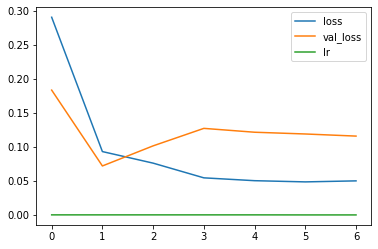

In [74]:
pd.DataFrame(history.history).plot()

In [75]:
print('Total time taken:', time.time() - t1 )

Total time taken: 59.76650094985962


In [80]:
model.load_weights('/content/weights-improvement-58-0.04.hdf5')

In [82]:
predictions= model.predict([x_test,x_test], verbose = True)

9/9 [==============================] - 0s 34ms/step


In [83]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.10196320822967508

In [84]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [88]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [89]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

567.84814453125

In [90]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  257.000000
mean    11.913023
std     99.432563
min   -279.250000
25%    -40.000000
50%     10.899414
75%     63.599609
max    795.900390

Summary of predicted opening price changes
                 
count  257.000000
mean  -559.163679
std     53.856011
min   -595.373047
25%   -592.063354
50%   -582.299316
75%   -548.719666
max   -287.663696


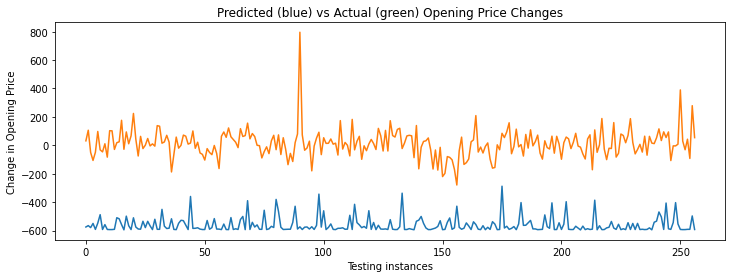

In [91]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [92]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [93]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 44.36% of the time.


Own prediction


In [94]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [95]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [96]:
# Default news that you can use
create_news = "Leaked document reveals Facebook conducted research to target emotionally vulnerable and insecure youth. \
               Woman says note from Chinese 'prisoner' was hidden in new purse. \
               21,000 AT&T workers poised for Monday strike \
               housands march against Trump climate policies in D.C., across USA \
               Kentucky judge won't hear gay adoptions because it's not in the child's \"best interest\" \
               Multiple victims shot in UTC area apartment complex \
               Drones Lead Police to Illegal Dumping in Riverside County | NBC Southern California \
               An 86-year-old Californian woman has died trying to fight a man who was allegedly sexually assaulting her 61-year-old friend. \
               Fyre Festival Named in $5Million+ Lawsuit after Stranding Festival-Goers on Island with Little Food, No Security. \
               The \"Greatest Show on Earth\" folds its tent for good \
               U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
               Woman offers undercover officer sex for $25 and some Chicken McNuggets \
               Ohio bridge refuses to fall down after three implosion attempts \
               Jersey Shore MIT grad dies in prank falling from library dome \
               New York graffiti artists claim McDonald's stole work for latest burger campaign \
               SpaceX to launch secretive satellite for U.S. intelligence agency \
               Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
               Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
               Baker Police officer arrested for allegedly covering up details in shots fired investigation \
               Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
               Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
               South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
               The Latest: Deal reached on funding government through Sept. \
               Russia flaunts Arctic expansion with new military bases"

In [99]:
def predict(create_news):
  clean_news = clean_text(create_news)

  int_news = news_to_int(clean_news)

  pad_news = padding_news(int_news)

  pad_news = np.array(pad_news).reshape((1,-1))

  pred = model.predict([pad_news,pad_news])

  price_change = unnormalize(pred)

  print("The Nifty should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

In [100]:
predict(create_news)

The Nifty should open: -403.9100036621094 from the previous open.


In [101]:
news = 'New party has won the election'
predict(news)

The Nifty should open: -592.0599975585938 from the previous open.
